In [1]:
def update_dist(r, support, probs, lim=(-10.0, 10.0), gamma=0.8):
    nsup = probs.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax - vmin) / (nsup - 1.0)  # A
    bj = np.round((r - vmin) / dz)  # B
    bj = int(np.clip(bj, 0, nsup - 1))  # C
    m = probs.clone()
    j = 1
    for i in range(bj, 1, -1):  # D
        m[i] += np.power(gamma, j) * m[i - 1]
        j += 1
    j = 1
    for i in range(bj, nsup - 1, 1):  # E
        m[i] += np.power(gamma, j) * m[i + 1]
        j += 1
    m /= m.sum()  # F
    return m

<BarContainer object of 51 artists>

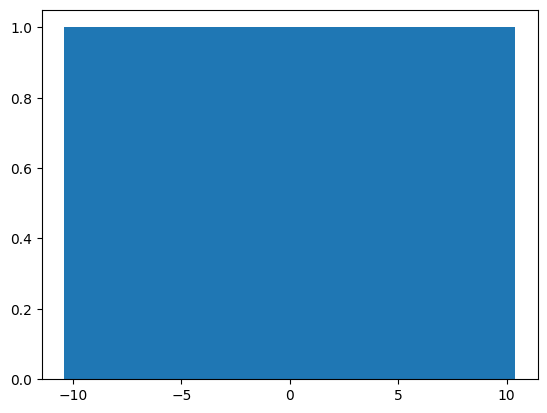

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

vmin, vmax = -10.0, 10.0
nsup = 51
support = np.linspace(vmin, vmax, nsup)
probs = np.ones(nsup)
props = probs.sum()
plt.bar(support, probs)

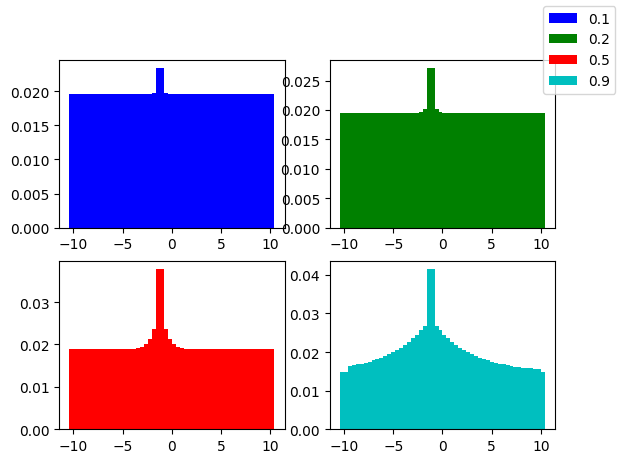

In [3]:
fig, axs = plt.subplots(2, 2)

axs = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]

for i, gamma in enumerate([0.1, 0.2, 0.5, 0.9]):
    ob_reward = -1
    Z = torch.from_numpy(probs).float()
    Z = update_dist(
        ob_reward, torch.from_numpy(support).float(), Z, lim=(vmin, vmax), gamma=gamma
    )
    axs[i].bar(support, Z, color="bgrc"[i])
fig.legend(["0.1", "0.2", "0.5", "0.9"])

<BarContainer object of 51 artists>

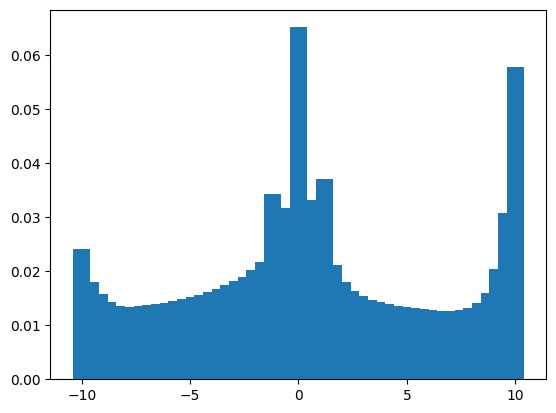

In [4]:
ob_rewards = [10, 10, 10, 0, 1, 0, -10, -10, 10, 10]
for i in range(len(ob_rewards)):
    Z = update_dist(
        ob_rewards[i], torch.from_numpy(support).float(), Z, lim=(vmin, vmax), gamma=0.5
    )
plt.bar(support, Z)

<BarContainer object of 51 artists>

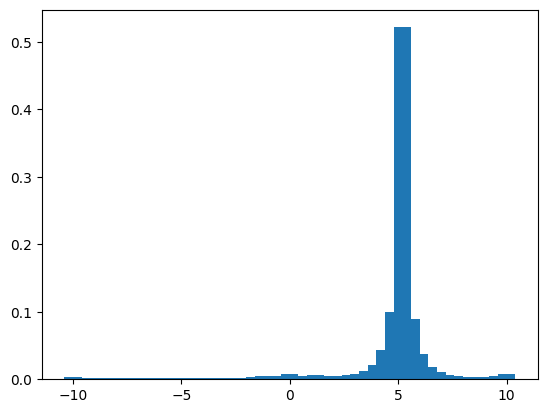

In [5]:
ob_rewards = [5 for i in range(15)]
for i in range(len(ob_rewards)):
    Z = update_dist(
        ob_rewards[i], torch.from_numpy(support).float(), Z, lim=(vmin, vmax), gamma=0.7
    )
plt.bar(support, Z)

In [6]:
def dist_dqn(x, theta, action_space=3):
    dim0, dim1, dim2, dim3 = 128, 100, 25, 51
    t1 = dim0 * dim1
    t2 = dim2 * dim1
    theta1 = theta[0:t1].reshape(dim0, dim1)
    theta2 = theta[t1 : t1 + t2].reshape(dim1, dim2)
    # Shape: B x 128 x 128 x 100 = B x 100
    # where B is the batch size.
    l1 = x @ theta1
    l1 = torch.selu(l1)
    # Shape: B x 100 x 100 x 25 = B x 25
    l2 = l1 @ theta2
    l2 = torch.selu(l2)
    l3 = []
    for i in range(action_space):
        step = dim2 * dim3
        theta5_dim = t1 + t2 + i * step
        theta5 = theta[theta5_dim : theta5_dim + step].reshape(dim2, dim3)
        # B x 25 x 25 x 51 = B x 51
        l3_ = l2 @ theta5
        l3.append(l3_)
    # B x 3 x 51
    l3 = torch.stack(l3, dim=1)
    l3 = torch.nn.functional.softmax(l3, dim=2)
    return l3.squeeze()

In [7]:
def get_target_dist(
    dist_batch, action_batch, reward_batch, support, lim=(-10, 10), gamma=0.8
):
    nsup = support.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax - vmin) / (nsup - 1.0)
    target_dist_batch = dist_batch.clone()

    # Loop through the batch dimension.
    for i in range(dist_batch.shape[0]):
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]

        # If the reward is not -1, it is a terminal state and the target
        # is a degenerate distribution at the reward value.
        if r != -1:
            target_dist = torch.zeros(nsup)
            bj = np.round((r - vmin) / dz)
            bj = int(np.clip(bj, 0, nsup - 1))
            target_dist[bj] = 1.0
        else:
            # If the target is nonterminal, the target distribution is a Bayesian
            # update of the prior given the reward.
            target_dist = update_dist(r, support, dist, lim=lim, gamma=gamma)
        target_dist_batch[i, action, :] = target_dist
    return target_dist_batch

In [8]:
def lossfn(x, y):
    """The cross-entropy loss between prediction distribution x and target distribution y"""
    # X dimension is B x 3 x 51
    loss = torch.Tensor([0.0])
    loss.requires_grad = True
    for i in range(x.shape[0]):
        loss_ = -1 * torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0)
        loss = loss + loss_
    return loss

## Dist-DQN on simulated data

This code test Dist-DQN's ability to learn the distribution for two samples of synthetic data. In our synthetic data, action 0 is associated with a reward of 0, and action 2 is associated with a reward of 10.
We expect the Dist-DQN to learn that state 1 is associated with action 1 and state 2 with action 2 and learn the distributions.

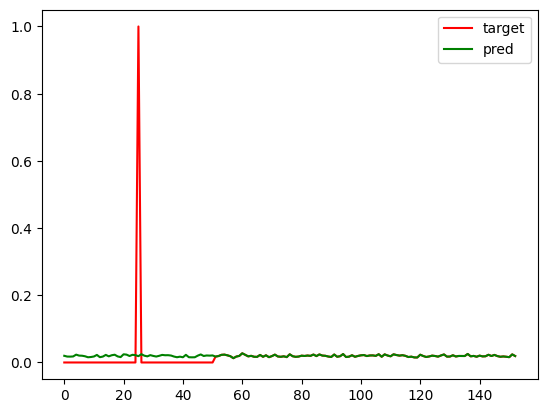

In [9]:
action_space = 3

# Defines the total number of Dist-DQN parameters based on layer sizes.
tot_params = 128 * 100 + 25 * 100 + action_space * 25 * 51

# Randomly initializes a parameter vector for Dist-DQN.
theta = torch.randn(tot_params) / 10.0
theta.requires_grad = True

# Clone theta to use as a target network.
theta_2 = theta.detach().clone()

vmin, vmax = -10, 10
gamma = 0.9
lr = 0.0001

# Synchronize the main and target Dist-DQN parameters every 75 steps.
update_rate = 75
support = torch.linspace(-10, 10, 51)

# Randomly initialize the two states for testing.
state = torch.randn(2, 128) / 10.0

action_batch = torch.Tensor([0, 2])
reward_batch = torch.Tensor([0, 10])
losses = []
pred_batch = dist_dqn(state, theta, action_space=action_space)
target_dist = get_target_dist(
    pred_batch, action_batch, reward_batch, support, lim=(vmin, vmax), gamma=gamma
)
plt.plot(
    (target_dist.flatten(start_dim=1)[0].data.numpy()), color="red", label="target"
)
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()), color="green", label="pred")
plt.legend()

/var/folders/7m/74_ct3hx33d878n626w1wxyc0000gn/T/ipykernel_2906/2425313810.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 466.90it/s]


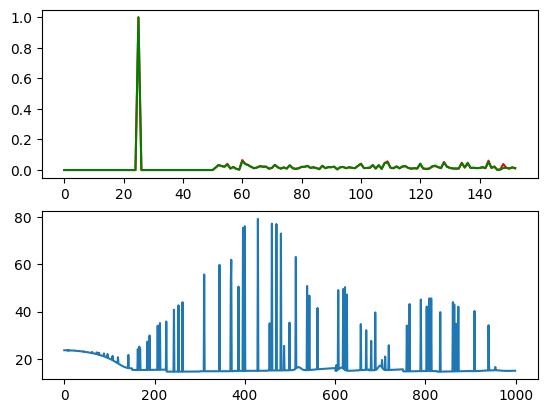

In [10]:
from tqdm.autonotebook import tqdm

for i in tqdm(range(1_000)):
    reward_batch = torch.Tensor([0, 8]) + torch.randn(2) / 10.0
    pred_batch = dist_dqn(state, theta, action_space=action_space)

    # Uses the target network's distribution to create the target distribution for learning.
    pred_batch2 = dist_dqn(state, theta_2, action_space=action_space)
    target_dist = get_target_dist(
        pred_batch2, action_batch, reward_batch, support, lim=(vmin, vmax), gamma=gamma
    )

    # Uses the main model's distribution prediction in the loss function.
    loss = lossfn(pred_batch, target_dist.detach())
    losses.append(loss.item())
    loss.backward()

    # Gradient descent.
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True
    if i % update_rate == 0:
        theta_2 = theta.detach().clone()

fig, ax = plt.subplots(2)
ax[0].plot(
    (target_dist.flatten(start_dim=1)[0].data.numpy()), color="red", label="target"
)
ax[0].plot(
    (pred_batch.flatten(start_dim=1)[0].data.numpy()), color="green", label="pred"
)
ax[1].plot(losses)

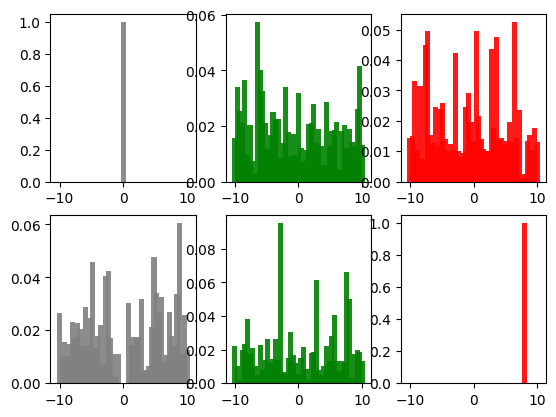

In [11]:
tpred = pred_batch
cs = ["gray", "green", "red"]
num_batch = 2
labels = [f"Action {i}" for i in range(action_space)]
fig, ax = plt.subplots(nrows=num_batch, ncols=action_space)
for j in range(num_batch):
    for i in range(tpred.shape[1]):
        ax[j, i].bar(
            support.data.numpy(),
            tpred[j, i, :].data.numpy(),
            label=f"Action {i}",
            alpha=0.9,
            color=cs[i],
        )

Each row contains the action-value distributions for an individual state, and each column in a row is the distribution for action 0, 1 and 2 respectively.

In [19]:
def preproc_state(state):
    p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state, dim=1)
    return p_state


def get_action(dist, support):
    actions = []
    for b in range(dist.shape[0]):
        expectations = [support @ dist[b, a, :] for a in range(dist.shape[1])]
        action = int(np.argmax(expectations))
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [20]:
from collections import deque

import gymnasium as gym

# pip install 'gymnasium[atari,accept-rom-license]'
env = gym.make("Freeway-ram-v0")
action_space = 3
env.env.get_action_meanings()

vmin, vmax = -10, 10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup - 1)
support = torch.linspace(vmin, vmax, nsup)
replay = deque(maxlen=replay_size)
lr = 0.0001
gamma = 0.1
epochs = 1300

# Starting epsilon for epsilon-greedy policy.
eps = 0.20
eps_min = 0.05

# Prioritized-replay; duplicates highly informative experiences in this replay many times.
priority_level = 5
update_freq = 25

# Initialize the DQN parameter vector
tot_params = 128 * 100 + 25 * 100 + action_space * 25 * 51
theta = torch.randn(tot_params) / 10.0
theta.requires_grad = True
theta_2 = theta.detach().clone()
losses = []
cum_rewards = []
renders = []
obs, info = env.reset()
state = preproc_state(obs)

In [21]:
from random import shuffle

for i in tqdm(range(epochs)):
    pred = dist_dqn(state, theta, action_space=action_space)
    if i < replay_size or np.random.rand(1) < eps:
        action = np.random.randint(action_space)
    else:
        action = get_action(pred.unsqueeze(dim=0).detach(), support).item()
    state2, reward, done, truncated, info = env.step(action)
    state2 = preproc_state(state2)
    if reward == 1:
        cum_rewards.append(1)
    reward = 10 if reward == 1 else reward
    reward = -10 if done else reward
    reward = -1 if reward == 0 else reward
    exp = (state, action, reward, state2)
    replay.append(exp)

    # If reward is 10, that indicates a succesful crossing,
    # and we want to amplify this experience.
    if reward == 10:
        for e in range(priority_level):
            replay.append(exp)
    shuffle(replay)
    state = state2

    if len(replay) == replay_size:
        indx = np.random.randint(low=0, high=len(replay), size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([s for (s, a, r, s2) in exps], dim=1).squeeze()
        action_batch = torch.Tensor([a for (s, a, r, s2) in exps])
        reward_batch = torch.Tensor([r for (s, a, r, s2) in exps])
        state2_batch = torch.stack([s2 for (s, a, r, s2) in exps], dim=1).squeeze()
        pred_batch = dist_dqn(state_batch.detach(), theta, action_space=action_space)
        pred2_batch = dist_dqn(
            state2_batch.detach(), theta_2, action_space=action_space
        )
        target_dist = get_target_dist(
            pred2_batch,
            action_batch,
            reward_batch,
            support,
            lim=(vmin, vmax),
            gamma=gamma,
        )
        loss = lossfn(pred_batch, target_dist.detach())
        losses.append(loss.item())
        loss.backward()
        with torch.no_grad():
            theta -= lr * theta.grad
        theta.requires_grad = True
    if i % update_freq == 0:
        theta_2 = theta.detach().clone()
    if i > 100 and eps > eps_min:
        dec = 1.0 / np.log2(i)
        dec /= 1e3
        eps -= dec

    if done:
        state = preproc_state(env.reset())
        done = False

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1300/1300 [01:44<00:00, 12.50it/s]


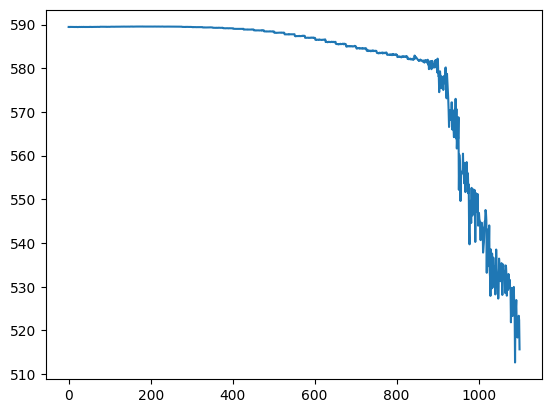

In [22]:
plt.plot(losses)